<div align="center">
  <a href="https://netspresso.ai/?utm_source=colab_bp&utm_medium=banner_py&utm_campaign=np_renew" target="_blank">
  <img src="https://netspresso-docs-imgs.s3.ap-northeast-2.amazonaws.com/imgs/banner/NetsPresso2.0_banner.png"/>
</div>

# Install NetsPresso

## Prerequisites

- Python `3.8` | `3.9` | `3.10`
- PyTorch `1.13.0` (recommended) (compatible with: `1.11.x` - `1.13.x`)
- TensorFlow `2.8.0` (recommended) (compatible with: `2.3.x` - `2.8.x`)

To use **editable mode** or **docker**, see [INSTALLATION.md](https://github.com/Nota-NetsPresso/PyNetsPresso/blob/develop/INSTALLATION.md).

## Install with PyPI

In [1]:
!python --version

Python 3.10.8


In [ ]:
!pip install netspresso==1.14.0

# Login NetsPresso

In [1]:
from netspresso import NetsPresso, NPQAI


EMAIL = "YOUR_EMAIL"
PASSWORD = "YOUR_PASSWORD"
QAI_HUB_API_TOKEN = "YOUR_QAI_HUB_API_TOKEN"

netspresso = NetsPresso(email=EMAIL, password=PASSWORD)
np_qai = NPQAI(api_token=QAI_HUB_API_TOKEN)

2025-02-13 04:07:41.669 | INFO     | netspresso.clients.config:_print_host_and_port:41 - Host: https://v2-prod.netspresso.ai, Port: 43001
2025-02-13 04:07:46.184 | INFO     | netspresso.clients.auth.v2.client:login:35 - Login successfully
2025-02-13 04:07:46.463 | INFO     | netspresso.clients.auth.v2.client:get_user_info:44 - Successfully got user information
2025-02-13 04:07:46.987 | INFO     | netspresso.netspresso:__init__:160 - CompletedProcess(args=['qai-hub', 'configure', '--api_token', '10ddcf0c0d02113d455ebe1e527f98db5b458593'], returncode=0, stdout='qai-hub configuration saved to /root/.qai_hub/client.ini\n==================== /root/.qai_hub/client.ini ====================\n[api]\napi_token = 10ddcf0c0d02113d455ebe1e527f98db5b458593\napi_url = https://app.aihub.qualcomm.com\nweb_url = https://app.aihub.qualcomm.com\nverbose = True\n\n\n', stderr='/opt/conda/lib/python3.10/site-packages/qai_hub/_cli.py:358: UserWarning: Overwriting configuration: /root/.qai_hub/client.ini (pre

# 1. Train the model(using YOLOX)

## 1-1. Download Dataset

In [2]:
!wget https://netspresso-github.s3.ap-northeast-2.amazonaws.com/traffic-sign.zip
!unzip traffic-sign.zip

--2025-02-13 04:07:47--  https://netspresso-github.s3.ap-northeast-2.amazonaws.com/traffic-sign.zip
Resolving netspresso-github.s3.ap-northeast-2.amazonaws.com (netspresso-github.s3.ap-northeast-2.amazonaws.com)... 52.219.148.58, 3.5.144.176, 3.5.186.78, ...
Connecting to netspresso-github.s3.ap-northeast-2.amazonaws.com (netspresso-github.s3.ap-northeast-2.amazonaws.com)|52.219.148.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261469534 (249M) [application/zip]
Saving to: ‘traffic-sign.zip’

traffic-sign.zip    100%[===================>] 249.36M  40.3MB/s    in 6.5s    

2025-02-13 04:07:54 (38.2 MB/s) - ‘traffic-sign.zip’ saved [261469534/261469534]

Archive:  traffic-sign.zip
   creating: traffic-sign/
   creating: traffic-sign/images/
   creating: traffic-sign/images/train/
  inflating: traffic-sign/images/train/00000.jpg  
  inflating: traffic-sign/images/train/00001.jpg  
  inflating: traffic-sign/images/train/00003.jpg  
  inflating: traffic-sign/i

## 1-2. Train the model

In [7]:
from netspresso.enums import Task
from netspresso.trainer.augmentations import Resize, ToTensor, Normalize
from netspresso.trainer.optimizers import AdamW
from netspresso.trainer.schedulers import CosineAnnealingWarmRestartsWithCustomWarmUp

IMG_SIZE=512

# 1. Declare trainer
trainer = netspresso.trainer(task=Task.OBJECT_DETECTION)
trainer.set_dataset_config(
    name="traffic_sign_config_example",
    root_path="./traffic-sign",
    train_image="images/train",
    train_label="labels/train",
    valid_image="images/valid",
    valid_label="labels/valid",
    id_mapping=["prohibitory", "danger", "mandatory", "other"],
)
trainer.set_model_config(model_name="YOLOX-S", img_size=IMG_SIZE)
trainer.set_augmentation_config(
    train_transforms=[Resize(), ToTensor(), Normalize()],
    inference_transforms=[Resize(), ToTensor(), Normalize()],
)
trainer.set_training_config(
    epochs=45,
    batch_size=64,
    optimizer=AdamW(lr=6e-3),
    scheduler=CosineAnnealingWarmRestartsWithCustomWarmUp(warmup_epochs=10),
)
project_name = "qai-hub-yolox-s"
trained_result = trainer.train(gpus="0, 1", project_name=project_name)

2025-02-13 04:08:59.544 | INFO     | netspresso.utils.file:create_unique_folder:90 - The folder has been created. Local Path: outputs/qai-hub-yolox-s (1)
2025-02-13 04:08:59.547 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/metadata.json
/opt/conda/lib/python3.10/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for op

# 2. Benchmark the trained model on QCS6490

## 2-0. Create calibration datasets

### Using good, representative input samples for calibration helps improve performance on target hardware and retains model accuracy

In [8]:
import cv2
from glob import glob

import numpy as np
from netspresso.inferencer.preprocessors.base import Preprocessor

preprocess_list = [
    {
        "name": "resize",
        "size": IMG_SIZE,
        "interpolation": "bilinear",
        "max_size": None,
        "resize_criteria": "long",
    },
    {
        "name": "pad",
        "size": IMG_SIZE,
        "fill": 114,
    }
]

preprocessor = Preprocessor(preprocess_list)

dataset_path = "./traffic-sign/images/train"
num_dataset = 100
image_paths = glob(f"{dataset_path}/*.jpg")[:num_dataset]

inputs_array = []

for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocessor(img)
    img = np.transpose(img, (0, 3, 1, 2))
    inputs_array.append(img)

In [9]:
np.array(inputs_array).shape

(100, 1, 3, 512, 512)

## 2-1. Quantize the trained model using Qualcomm AI Hub

### This provides an ONNX model with weights quantized to int8 and activations quantized to int8.

In [10]:
import time

from netspresso.np_qai.options import CompileOptions, Runtime, ComputeUnit, ProfileOptions, TfliteOptions, QuantizePrecision

quantizer = np_qai.quantizer()

calibration_data = {"images": inputs_array}

quantized_result = quantizer.quantize_model(
    input_model_path=trained_result.best_onnx_model_path,
    output_dir=f"{trained_result.output_dir}/quantized/trained_model_w8a8",
    calibration_data=calibration_data,
    weights_dtype=QuantizePrecision.INT8,
    activations_dtype=QuantizePrecision.INT8,
    job_name="detection_yolox_s_w8a8",
)
print("Quantization task started")

# Monitor task status
while True:
    status = quantizer.get_quantize_task_status(quantized_result.quantize_info.quantize_task_uuid)
    if status.finished:
        quantized_result = quantizer.update_quantize_task(quantized_result)
        print("Quantization task completed")
        break
    else:
        time.sleep(30)
        print("Quantization task is still running")

2025-02-13 04:15:33.941 | INFO     | netspresso.utils.file:create_unique_folder:82 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/trained_model_w8a8
2025-02-13 04:15:33.944 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/trained_model_w8a8/metadata.json


Uploading detection_yolox_s_best.onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34.1M/34.1M [00:05<00:00, 6.47MB/s]
Uploading dataset: 45.6MB [00:05, 8.83MB/s]                                                                                                                                                                       9.25MB/s]
2025-02-13 04:15:53.255 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/trained_model_w8a8/metadata.json


Scheduled quantize job (j5ww32q65) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j5ww32q65/

Quantization task started
Quantization task is still running
Quantization task is still running
Quantization task is still running


2025-02-13 04:17:26.970 | INFO     | netspresso.np_qai.quantizer:update_quantize_task:51 - ✅ SUCCESS
trained_model_w8a8.onnx: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34.4M/34.4M [00:01<00:00, 24.0MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/trained_model_w8a8/trained_model_w8a8.onnx


2025-02-13 04:17:30.013 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/trained_model_w8a8/metadata.json


Quantization task completed


## 2-2. Compile and Optimize the quantized model using Qualcomm AI Hub

In [11]:
from netspresso.np_qai import Device
from netspresso.np_qai.options import CompileOptions, Runtime, ComputeUnit, ProfileOptions, TfliteOptions, QuantizeFullType

converter = np_qai.converter()

convert_options = CompileOptions(
    target_runtime=Runtime.TFLITE,
    compute_unit=[ComputeUnit.NPU],
    quantize_full_type=QuantizeFullType.INT8,
    quantize_io=True,
    quantize_io_type=QuantizeFullType.INT8,
)

converted_result = converter.convert_model(
    input_model_path=quantized_result.quantized_model_path,
    output_dir=f"{trained_result.output_dir}/converted/quantized_model_tflite",
    target_device_name=Device("QCS6490 (Proxy)"),
    options=convert_options,
    input_shapes=dict(image=(1, 3, IMG_SIZE, IMG_SIZE)),
    job_name=f"detection_yolox_s_tflite",
)

print("Conversion task started")

# Monitor task status
while True:
    status = converter.get_convert_task_status(converted_result.convert_task_info.convert_task_uuid)
    if status.finished:
        converted_result = converter.update_convert_task(converted_result)
        print("Conversion task completed")
        break
    else:
        time.sleep(30)
        print("Conversion task is still running")

2025-02-13 04:17:30.037 | INFO     | netspresso.utils.file:create_unique_folder:82 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite
2025-02-13 04:17:30.041 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite/metadata.json


Uploading trained_model_w8a8.onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34.4M/34.4M [00:03<00:00, 9.71MB/s]
2025-02-13 04:17:35.499 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite/metadata.json


Scheduled compile job (jp12wye2g) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp12wye2g/

Conversion task started
Conversion task is still running
Conversion task is still running


2025-02-13 04:18:38.119 | INFO     | netspresso.np_qai.converter:update_convert_task:58 - ✅ SUCCESS
quantized_model_tflite.tflite: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.89M/8.89M [00:00<00:00, 10.3MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite/quantized_model_tflite.tflite


2025-02-13 04:18:40.768 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite/metadata.json


Conversion task completed


## 2-3. Benchmark the performance on-device using Qualcomm AI Hub

### Visit your job on [Qualcomm AI Hub](https://app.aihub.qualcomm.com/jobs/) to see other inference metrics like memory usage, load time, layer by layer analysis and model visualization.

In [12]:
benchmarker = np_qai.benchmarker()

benchmark_options = ProfileOptions(
    compute_unit=[ComputeUnit.NPU],
    tflite_options=TfliteOptions(number_of_threads=4),
)

benchmark_result = benchmarker.benchmark_model(
    input_model_path=converted_result.converted_model_path,
    target_device_name=Device("QCS6490 (Proxy)"),
    options=benchmark_options,
)

# Monitor task status
while True:
    status = benchmarker.get_benchmark_task_status(benchmark_result.benchmark_task_info.benchmark_task_uuid)
    if status.finished:
        benchmark_result = benchmarker.update_benchmark_task(benchmark_result)
        print("Benchmark task completed")
        break
    else:
        time.sleep(30)
        print("Benchmark task is still running")

print(benchmark_result)

2025-02-13 04:18:40.791 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite/benchmark.json


Uploading quantized_model_tflite.tflite


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.89M/8.89M [00:02<00:00, 3.27MB/s]
2025-02-13 04:18:45.240 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite/benchmark.json


Scheduled profile job (j5ww32q35) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j5ww32q35/

Benchmark task is still running
Benchmark task is still running
Benchmark task is still running
Benchmark task is still running
Benchmark task is still running
Benchmark task is still running


2025-02-13 04:21:50.933 | INFO     | netspresso.np_qai.benchmarker:update_benchmark_task:86 - ✅ SUCCESS
2025-02-13 04:21:51.485 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite/benchmark.json


Benchmark task completed
BenchmarkerMetadata(status=<Status.COMPLETED: 'completed'>, error_detail=ExceptionDetail(data=AdditionalData(origin='', error_log='', link=None), error_code='', name='', message=''), task_type=<TaskType.BENCHMARK: 'benchmark'>, input_model_path='/root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/quantized_model_tflite/quantized_model_tflite.tflite', benchmark_task_info=BenchmarkTaskInfo(benchmark_task_uuid='j5ww32q35', framework=<Framework.TFLITE: 'tensorflow_lite'>, display_framework='Tensorflow Lite', device_name='QCS6490 (Proxy)', display_device_name='QCS6490 (Proxy)', display_brand_name='', software_version='', display_software_version='', data_type='', hardware_type=''), benchmark_result=BenchmarkResult(memory_footprint=176136192, memory_footprint_gpu=None, memory_footprint_cpu=None, power_consumption=None, ram_size=None, latency=21.576, file_size=None))


In [13]:
print(f"Latency of trained model: {benchmark_result.benchmark_result.latency} ms")

Latency of trained model: 21.576 ms


# 3. Optimize the trained model using Compressor

## 3-1. Run automatic compression

In [33]:
ratios = [0.3, 0.5, 0.7]

compressor = netspresso.compressor_v2()
compressed_results = {}

for ratio in ratios:
    _compressed_result = compressor.automatic_compression(
        input_model_path=trained_result.best_fx_model_path,
        output_dir=f"{trained_result.output_dir}/compressed/pruning_{ratio}",
        input_shapes=trained_result.model_info.input_shapes,
        compression_ratio=ratio,
    )
    compressed_results[ratio] = _compressed_result

2025-02-13 04:44:28.055 | INFO     | netspresso.utils.file:create_unique_folder:82 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/compressed/pruning_0.3
2025-02-13 04:44:28.067 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/compressed/pruning_0.3/metadata.json
2025-02-13 04:44:28.069 | INFO     | netspresso.compressor.v2.compressor:automatic_compression:559 - Compressing automatic-based model...
2025-02-13 04:44:28.276 | INFO     | netspresso.clients.auth.v2.client:get_credit:60 - Successfully got user credit
2025-02-13 04:44:28.279 | INFO     | netspresso.compressor.v2.compressor:upload_model:168 - Uploading Model...
Uploading model: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34.4M/34.4M [00:03<00:00, 9.82MB/s]
2025-02-13 04:44:36.944 |

## 3-2. Quantize all the compressed models using Qualcomm AI Hub

In [34]:
quantize_tasks = {}
completed_quantize_tasks = set()

for ratio in ratios:
    _quantize_task = quantizer.quantize_model(
        input_model_path=compressed_results[ratio].compressed_onnx_model_path,
        output_dir=f"{trained_result.output_dir}/quantized/pruning_{ratio}_w8a8",
        calibration_data=calibration_data,
        weights_dtype=QuantizePrecision.INT8,
        activations_dtype=QuantizePrecision.INT8,
    )
    quantize_tasks[ratio] = _quantize_task
    print(f"Compressed model({ratio}) quantize task started")

while len(completed_quantize_tasks) < len(ratios):
    for ratio in ratios:
        if ratio not in completed_quantize_tasks:
            status = quantizer.get_quantize_task_status(quantize_tasks[ratio].quantize_info.quantize_task_uuid)
            if status.finished:
                quantize_tasks[ratio] = quantizer.update_quantize_task(quantize_tasks[ratio])
                completed_quantize_tasks.add(ratio)
                print(f"Compressed model({ratio}) quantize task completed")
            else:
                time.sleep(30)
                print(f"Compressed model({ratio}) quantize task is still running")

print("All tasks completed!")

2025-02-13 04:45:48.693 | INFO     | netspresso.utils.file:create_unique_folder:82 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.3_w8a8
2025-02-13 04:45:48.698 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.3_w8a8/metadata.json


Uploading pruning_0.3.onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17.1M/17.1M [00:01<00:00, 9.39MB/s]
Uploading dataset: 45.6MB [00:04, 10.1MB/s]                                                                                                                                                                       10.3MB/s]
2025-02-13 04:46:03.656 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.3_w8a8/metadata.json
2025-02-13 04:46:03.659 | INFO     | netspresso.utils.file:create_unique_folder:90 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.5_w8a8 (1)
2025-02-13 04:46:03.663 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)

Scheduled quantize job (jgn0mlek5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgn0mlek5/

Compressed model(0.3) quantize task started
Uploading pruning_0.5 (1).onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.96M/8.96M [00:01<00:00, 5.57MB/s]
Uploading dataset: 45.6MB [00:04, 9.77MB/s]                                                                                                                                                                       11.0MB/s]
2025-02-13 04:46:17.350 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.5_w8a8 (1)/metadata.json
2025-02-13 04:46:17.353 | INFO     | netspresso.utils.file:create_unique_folder:90 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.7_w8a8 (1)
2025-02-13 04:46:17.357 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s

Scheduled quantize job (jpr628y0p) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpr628y0p/

Compressed model(0.5) quantize task started
Uploading pruning_0.7 (1).onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.33M/3.33M [00:01<00:00, 2.41MB/s]
Uploading dataset: 45.6MB [00:04, 10.5MB/s]                                                                                                                                                                       8.72MB/s]
2025-02-13 04:46:30.873 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.7_w8a8 (1)/metadata.json


Scheduled quantize job (jpyzjrd8g) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpyzjrd8g/

Compressed model(0.7) quantize task started
Compressed model(0.3) quantize task is still running
Compressed model(0.5) quantize task is still running


2025-02-13 04:47:33.686 | INFO     | netspresso.np_qai.quantizer:update_quantize_task:51 - ✅ SUCCESS
pruning_0.7_w8a8 (1).onnx: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.51M/3.51M [00:00<00:00, 5.84MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.7_w8a8 (1)/pruning_0.7_w8a8 (1).onnx


2025-02-13 04:47:35.840 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.7_w8a8 (1)/metadata.json


Compressed model(0.7) quantize task completed
Compressed model(0.3) quantize task is still running


2025-02-13 04:48:07.865 | INFO     | netspresso.np_qai.quantizer:update_quantize_task:51 - ✅ SUCCESS
pruning_0.5_w8a8 (1).onnx: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.15M/9.15M [00:00<00:00, 10.7MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.5_w8a8 (1)/pruning_0.5_w8a8 (1).onnx


2025-02-13 04:48:10.201 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.5_w8a8 (1)/metadata.json


Compressed model(0.5) quantize task completed


2025-02-13 04:48:11.099 | INFO     | netspresso.np_qai.quantizer:update_quantize_task:51 - ✅ SUCCESS
pruning_0.3_w8a8.onnx: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17.3M/17.3M [00:01<00:00, 16.8MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.3_w8a8/pruning_0.3_w8a8.onnx


2025-02-13 04:48:13.583 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/quantized/pruning_0.3_w8a8/metadata.json


Compressed model(0.3) quantize task completed
All tasks completed!


## 3-3. Compile and Optimize all model using Qualcomm AI Hub

In [35]:
converter = np_qai.converter()

convert_tasks = {}
completed_convert_tasks = set()


for ratio in ratios:
    _converted_result = converter.convert_model(
        input_model_path=quantize_tasks[ratio].quantized_model_path,
        output_dir=f"{trained_result.output_dir}/converted/pruning_{ratio}",
        target_device_name=Device("QCS6490 (Proxy)"),
        options=convert_options,
        input_shapes=dict(image=(1, 3, IMG_SIZE, IMG_SIZE)),
        job_name=f"yolox_s_compressed_{ratio}_tflite",
    )
    convert_tasks[ratio] = _converted_result
    print(f"Quantized model({ratio}) convert task started")

while len(completed_convert_tasks) < len(ratios):
    for ratio in ratios:
        if ratio not in completed_convert_tasks:
            status = converter.get_convert_task_status(convert_tasks[ratio].convert_task_info.convert_task_uuid)
            if status.finished:
                convert_tasks[ratio] = converter.update_convert_task(convert_tasks[ratio])
                completed_convert_tasks.add(ratio)
                print(f"Quantized model({ratio}) convert task completed")
            else:
                time.sleep(30)
                print(f"Quantized model({ratio}) convert task is still running")

print("All tasks completed!")

2025-02-13 04:48:13.612 | INFO     | netspresso.utils.file:create_unique_folder:82 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.3
2025-02-13 04:48:13.616 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.3/metadata.json


Uploading pruning_0.3_w8a8.onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17.3M/17.3M [00:03<00:00, 5.62MB/s]
2025-02-13 04:48:18.643 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.3/metadata.json
2025-02-13 04:48:18.646 | INFO     | netspresso.utils.file:create_unique_folder:90 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.5 (1)
2025-02-13 04:48:18.650 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.5 (1)/metadata.json


Scheduled compile job (j5q0re2np) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j5q0re2np/

Quantized model(0.3) convert task started
Uploading pruning_0.5_w8a8 (1).onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.15M/9.15M [00:02<00:00, 3.79MB/s]
2025-02-13 04:48:23.262 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.5 (1)/metadata.json
2025-02-13 04:48:23.265 | INFO     | netspresso.utils.file:create_unique_folder:90 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.7 (1)
2025-02-13 04:48:23.269 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.7 (1)/metadata.json


Scheduled compile job (jgl426kj5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgl426kj5/

Quantized model(0.5) convert task started
Uploading pruning_0.7_w8a8 (1).onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.51M/3.51M [00:01<00:00, 2.37MB/s]
2025-02-13 04:48:26.534 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.7 (1)/metadata.json


Scheduled compile job (jp3n1vm35) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp3n1vm35/

Quantized model(0.7) convert task started
Quantized model(0.3) convert task is still running
Quantized model(0.5) convert task is still running


2025-02-13 04:49:29.220 | INFO     | netspresso.np_qai.converter:update_convert_task:58 - ✅ SUCCESS
pruning_0.7 (1).tflite: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00M/1.00M [00:00<00:00, 2.81MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.7 (1)/pruning_0.7 (1).tflite


2025-02-13 04:49:31.044 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.7 (1)/metadata.json


Quantized model(0.7) convert task completed


2025-02-13 04:49:31.960 | INFO     | netspresso.np_qai.converter:update_convert_task:58 - ✅ SUCCESS
pruning_0.3.tflite: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.56M/4.56M [00:00<00:00, 6.51MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.3/pruning_0.3.tflite


2025-02-13 04:49:34.182 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.3/metadata.json


Quantized model(0.3) convert task completed


2025-02-13 04:49:35.071 | INFO     | netspresso.np_qai.converter:update_convert_task:58 - ✅ SUCCESS
pruning_0.5 (1).tflite: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.47M/2.47M [00:00<00:00, 4.23MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.5 (1)/pruning_0.5 (1).tflite


2025-02-13 04:49:36.801 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.5 (1)/metadata.json


Quantized model(0.5) convert task completed
All tasks completed!


## 3-4. Benchmark the performance across all models on-device using Qualcomm AI Hub

In [36]:
benchmarker = np_qai.benchmarker()

benchmark_tasks = {}
completed_benchmark_tasks = set()

for ratio in ratios:
    _benchmark_result = benchmarker.benchmark_model(
        input_model_path=convert_tasks[ratio].converted_model_path,
        target_device_name=Device("QCS6490 (Proxy)"),
        options=benchmark_options,
    )
    benchmark_tasks[ratio] = _benchmark_result
    print(f"Converted model({ratio}) benchmark task started")

while len(completed_benchmark_tasks) < len(ratios):
    for ratio in ratios:
        if ratio not in completed_benchmark_tasks:
            status = benchmarker.get_benchmark_task_status(benchmark_tasks[ratio].benchmark_task_info.benchmark_task_uuid)
            if status.finished:
                benchmark_tasks[ratio] = benchmarker.update_benchmark_task(benchmark_tasks[ratio])
                completed_benchmark_tasks.add(ratio)
                print(f"Converted model({ratio}) benchmark task completed")
            else:
                time.sleep(30)
                print(f"Converted model({ratio}) benchmark task is still running")

print("All tasks completed!")


2025-02-13 04:49:36.829 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.3/benchmark.json


Uploading pruning_0.3.tflite


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.56M/4.56M [00:01<00:00, 4.27MB/s]
2025-02-13 04:49:39.734 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.3/benchmark.json
2025-02-13 04:49:39.738 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.5 (1)/benchmark.json


Scheduled profile job (jpvqr01kg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpvqr01kg/

Converted model(0.3) benchmark task started
Uploading pruning_0.5 (1).tflite


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.47M/2.47M [00:01<00:00, 2.34MB/s]
2025-02-13 04:49:42.369 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.5 (1)/benchmark.json
2025-02-13 04:49:42.373 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.7 (1)/benchmark.json


Scheduled profile job (jgjd2z0vg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgjd2z0vg/

Converted model(0.5) benchmark task started
Uploading pruning_0.7 (1).tflite


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00M/1.00M [00:01<00:00, 769kB/s]
2025-02-13 04:49:45.214 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.7 (1)/benchmark.json


Scheduled profile job (jpeowerog) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpeowerog/

Converted model(0.7) benchmark task started
Converted model(0.3) benchmark task is still running
Converted model(0.5) benchmark task is still running
Converted model(0.7) benchmark task is still running
Converted model(0.3) benchmark task is still running
Converted model(0.5) benchmark task is still running
Converted model(0.7) benchmark task is still running


2025-02-13 04:52:50.744 | INFO     | netspresso.np_qai.benchmarker:update_benchmark_task:86 - ✅ SUCCESS
2025-02-13 04:52:51.388 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.3/benchmark.json


Converted model(0.3) benchmark task completed


2025-02-13 04:52:52.294 | INFO     | netspresso.np_qai.benchmarker:update_benchmark_task:86 - ✅ SUCCESS
2025-02-13 04:52:52.865 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.5 (1)/benchmark.json


Converted model(0.5) benchmark task completed
Converted model(0.7) benchmark task is still running
Converted model(0.7) benchmark task is still running
Converted model(0.7) benchmark task is still running
Converted model(0.7) benchmark task is still running
Converted model(0.7) benchmark task is still running


2025-02-13 04:55:27.702 | INFO     | netspresso.np_qai.benchmarker:update_benchmark_task:86 - ✅ SUCCESS
2025-02-13 04:55:28.288 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/qai-hub-yolox-s (1)/converted/pruning_0.7 (1)/benchmark.json


Converted model(0.7) benchmark task completed
All tasks completed!


## 3-5. Comparison of latency and FLOPs corresponding to the compression ratios

In [37]:
from netspresso.utils.plotter import Plotter

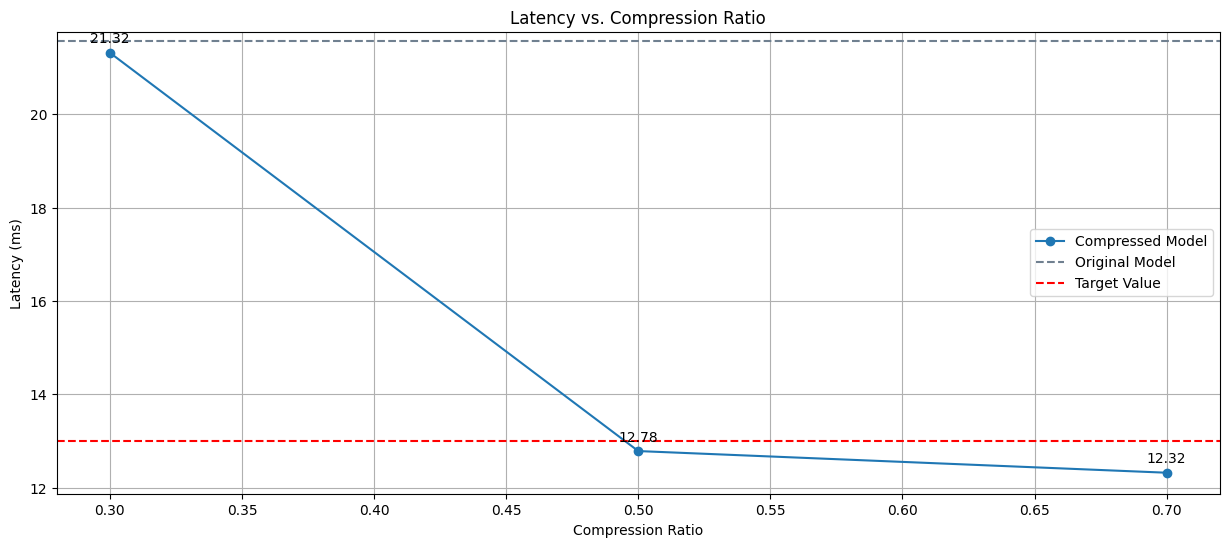

In [38]:
original_latency = benchmark_result.benchmark_result.latency
compressed_latency = {ratio : benchmark_tasks[ratio].benchmark_result.latency for ratio in ratios}
Plotter.compare_latency(original_latency=original_latency, latency_per_model=compressed_latency, target_latency=13)

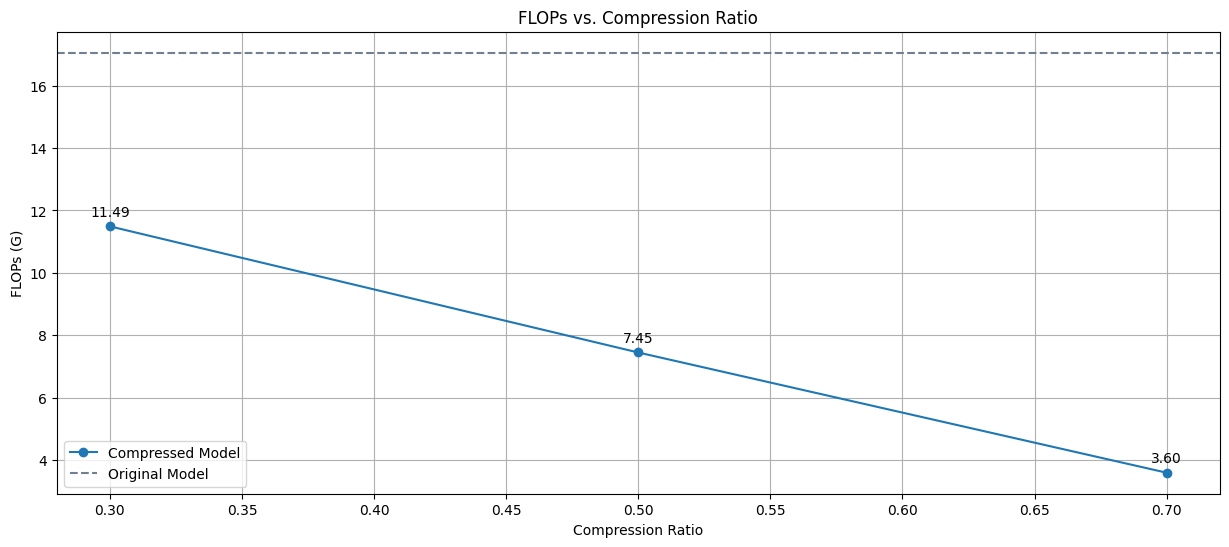

In [39]:
original_flops = compressed_results[0.3].results.original_model.flops
compressed_flops = {ratio : compressed_results[ratio].results.compressed_model.flops for ratio in ratios}
Plotter.compare_flops(original_flops=original_flops, flops_per_model=compressed_flops)

# 4. Retrain the compressed model

## 4-1. Train the compressed model

In [86]:
selected_pruning_ratio = 0.7 # The minimum pruning ratio required to achieve the target latency.

hparams_yaml = trained_result.hparams
compressed_model_path = compressed_results[selected_pruning_ratio].compressed_model_path

retrainer = netspresso.trainer(yaml_path=hparams_yaml)

retrainer.set_fx_model(fx_model_path=compressed_model_path)
retrainer.set_training_config(
    epochs=28,
    batch_size=64,
    optimizer=AdamW(lr=6e-3),
    scheduler=CosineAnnealingWarmRestartsWithCustomWarmUp(warmup_epochs=10),
)
project_name = "retraining_sample"
retraining_result = retrainer.train(gpus="0, 1", project_name=project_name)

2025-02-13 06:48:36.751 | INFO     | netspresso.utils.file:create_unique_folder:90 - The folder has been created. Local Path: outputs/retraining_sample (5)
2025-02-13 06:48:36.754 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/metadata.json
/opt/conda/lib/python3.10/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable fo

## 4-2. Comparison of performance metric between original model and compressed model

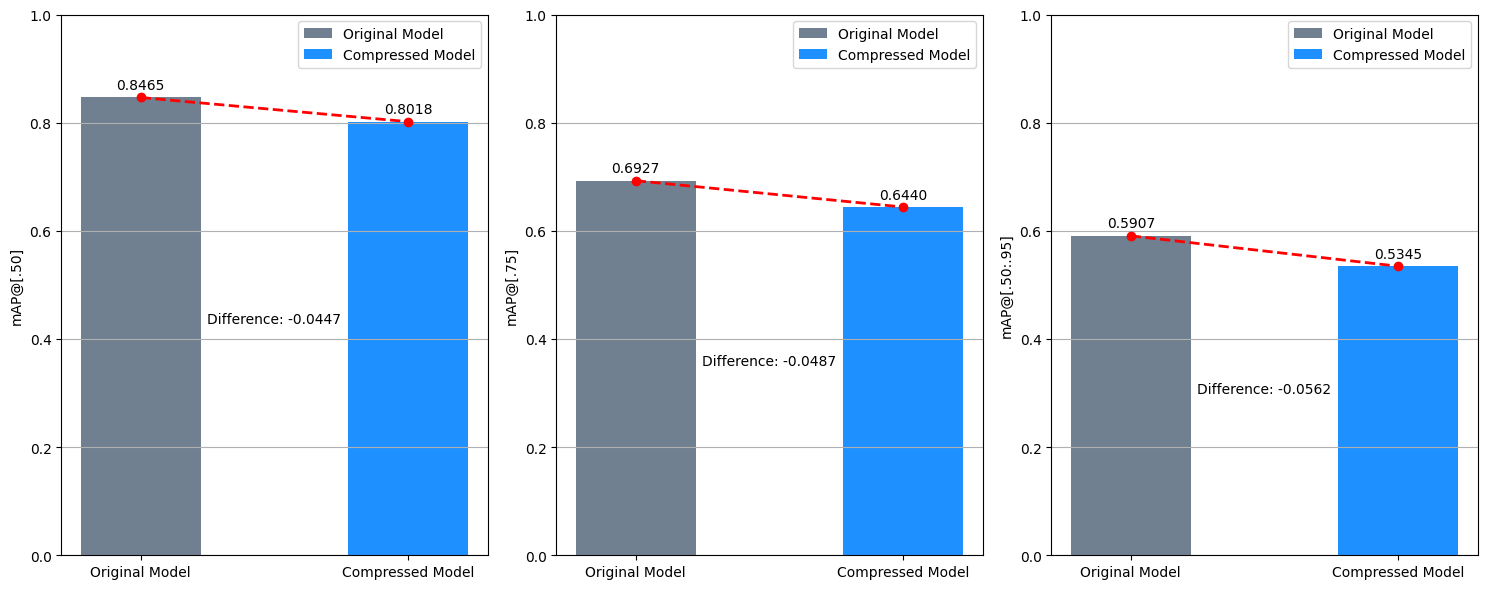

In [87]:
Plotter.compare_metric(trained_result, retraining_result)

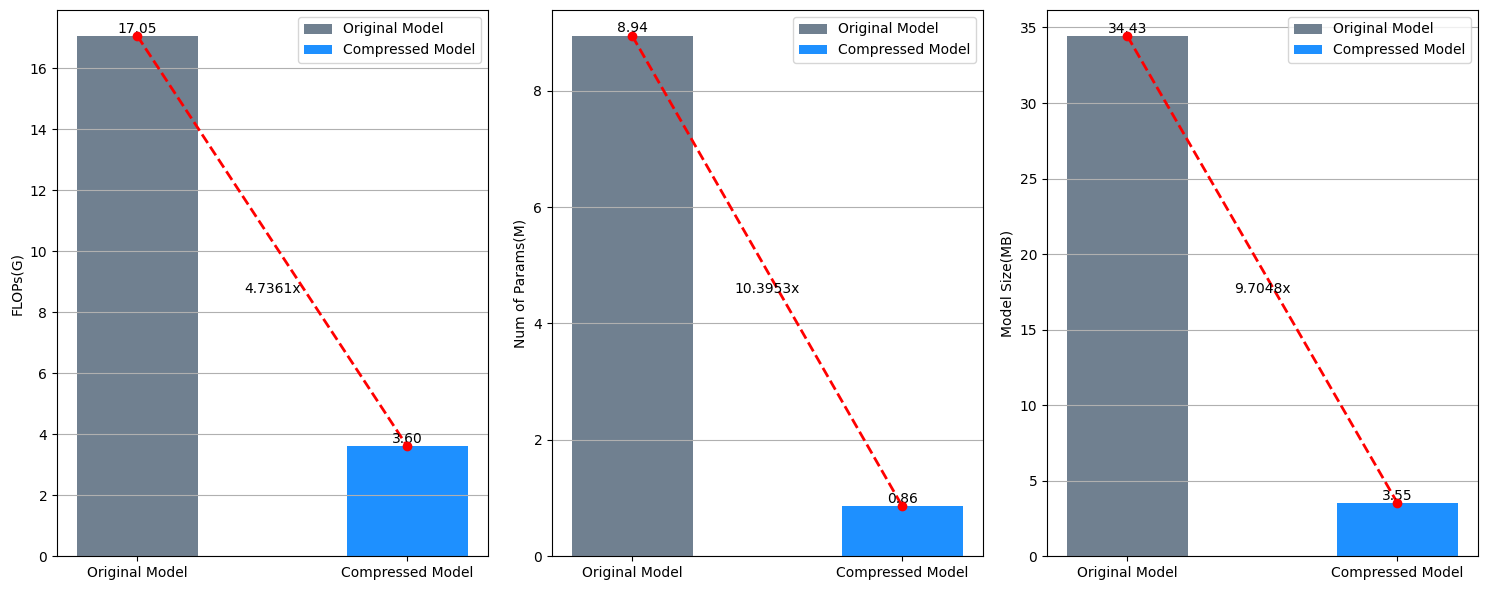

In [83]:
Plotter.compare_profile_result(compressed_results[selected_pruning_ratio])

# 5. Inference the retrained model

## 5-1. Quantize the retrained model using Qualcomm AI Hub

In [88]:
quantized_result = quantizer.quantize_model(
    input_model_path=retraining_result.best_onnx_model_path,
    output_dir=f"{retraining_result.output_dir}/quantized/trained_model_w8a8",
    calibration_data=calibration_data,
    weights_dtype=QuantizePrecision.INT8,
    activations_dtype=QuantizePrecision.INT8,
    job_name="detection_yolox_s_w8a8",
)
print("Quantization task started")

# Monitor task status
while True:
    status = quantizer.get_quantize_task_status(quantized_result.quantize_info.quantize_task_uuid)
    if status.finished:
        quantized_result = quantizer.update_quantize_task(quantized_result)
        print("Quantization task completed")
        break
    else:
        time.sleep(30)
        print("Quantization task is still running")

2025-02-13 06:54:08.415 | INFO     | netspresso.utils.file:create_unique_folder:82 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/quantized/trained_model_w8a8
2025-02-13 06:54:08.418 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/quantized/trained_model_w8a8/metadata.json


Uploading detection_yolox_s_best.onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34.1M/34.1M [00:03<00:00, 10.2MB/s]
Uploading dataset: 45.6MB [00:05, 9.48MB/s]                                                                                                                                                                       7.45MB/s]
2025-02-13 06:54:24.740 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/quantized/trained_model_w8a8/metadata.json


Scheduled quantize job (jgkvq70vp) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgkvq70vp/

Quantization task started
Quantization task is still running
Quantization task is still running
Quantization task is still running
Quantization task is still running
Quantization task is still running


2025-02-13 06:56:59.389 | INFO     | netspresso.np_qai.quantizer:update_quantize_task:51 - ✅ SUCCESS
trained_model_w8a8.onnx: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34.4M/34.4M [00:01<00:00, 23.8MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/quantized/trained_model_w8a8/trained_model_w8a8.onnx


2025-02-13 06:57:01.933 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/quantized/trained_model_w8a8/metadata.json


Quantization task completed


## 5-2. Compile and Optimize retrained model using Qualcomm AI Hub

In [89]:
converted_result = converter.convert_model(
    input_model_path=quantized_result.quantized_model_path,
    output_dir=f"{retraining_result.output_dir}/converted/quantized_model_tflite",
    target_device_name=Device("QCS6490 (Proxy)"),
    options=convert_options,
    input_shapes=dict(image=(1, 3, IMG_SIZE, IMG_SIZE)),
    job_name=f"detection_yolox_s_tflite",
)

print("Conversion task started")

# Monitor task status
while True:
    status = converter.get_convert_task_status(converted_result.convert_task_info.convert_task_uuid)
    if status.finished:
        converted_result = converter.update_convert_task(converted_result)
        print("Conversion task completed")
        break
    else:
        time.sleep(30)
        print("Conversion task is still running")

2025-02-13 06:57:01.954 | INFO     | netspresso.utils.file:create_unique_folder:82 - The folder has been created. Local Path: /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/converted/quantized_model_tflite
2025-02-13 06:57:01.958 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/converted/quantized_model_tflite/metadata.json


Uploading trained_model_w8a8.onnx


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34.4M/34.4M [00:05<00:00, 6.47MB/s]
2025-02-13 06:57:09.880 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/converted/quantized_model_tflite/metadata.json


Scheduled compile job (jgz2joy4g) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgz2joy4g/

Conversion task started
Conversion task is still running
Conversion task is still running


2025-02-13 06:58:11.962 | INFO     | netspresso.np_qai.converter:update_convert_task:58 - ✅ SUCCESS
quantized_model_tflite.tflite: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.89M/8.89M [00:00<00:00, 10.4MB/s]


Downloaded model to /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/converted/quantized_model_tflite/quantized_model_tflite.tflite


2025-02-13 06:58:14.367 | INFO     | netspresso.utils.metadata.handler:save_json:65 - JSON file saved at /root/projects/qc/v1.14.0/outputs/retraining_sample (5)/converted/quantized_model_tflite/metadata.json


Conversion task completed


## 5-3. Define preprocessor & postprocessor

In [90]:
import cv2
from glob import glob

from netspresso.inferencer.preprocessors.base import Preprocessor
from netspresso.inferencer.postprocessors.detection import DetectionPostprocessor as Postprocessor
from netspresso.inferencer.visualizers.detection import DetectionVisualizer as Visualizer

In [91]:
preprocess_list = [
    {
        "name": "resize",
        "size": IMG_SIZE,
        "interpolation": "bilinear",
        "max_size": None,
        "resize_criteria": "long",
    },
    {
        "name": "pad",
        "size": IMG_SIZE,
        "fill": 114,
    }
]

preprocessor = Preprocessor(preprocess_list)
postprocessor = Postprocessor(score_thresh=0.4, nms_thresh=0.65)
visualizer = Visualizer(class_map=["prohibitory", "danger", "mandatory", "other"], brightness_factor=1.5)

## 5-4. Preprocess

In [92]:
colored_img = cv2.imread("./traffic-sign/images/valid/00644.jpg")
img = cv2.cvtColor(colored_img, cv2.COLOR_BGR2RGB)
img_draw = img.copy()
img = preprocessor(img)
transposed_img = img.transpose(0, 3, 1, 2)

## 5-5. Run inference on-device using Qualcomm AI Hub

In [93]:
from netspresso.np_qai import Device
from netspresso.np_qai.options import CompileOptions, Runtime, ComputeUnit, ProfileOptions, TfliteOptions

inference_job = benchmarker.inference_model(
    input_model_path=converted_result.converted_model_path,
    target_device_name=Device(name="QCS6490 (Proxy)"),
    inputs=dict(image=[transposed_img]),
)

while True:
    status = benchmarker.get_inference_task_status(inference_job.job_id)
    if status.finished:
        print("Inference task completed")
        break
    else:
        time.sleep(30)
        print("Inference task is still running")

Uploading quantized_model_tflite.tflite


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.89M/8.89M [00:01<00:00, 4.90MB/s]
Uploading dataset: 595kB [00:01, 513kB/s]                                                                                                                                                                         <?, ?B/s]


Scheduled inference job (jgdnqe465) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgdnqe465/

Inference task is still running
Inference task is still running
Inference task is still running
Inference task is still running
Inference task is still running
Inference task is still running
Inference task completed


## 5-6. Download on-device output for QCS6490

In [94]:
output_data = inference_job.download_output_data()
output = [value[0] for key, value in output_data.items()]

tmpkcdge_52.h5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51.6k/51.6k [00:00<00:00, 14.4MB/s]


## 5-7. Postprocess

In [95]:
model_input_shape = img.shape[1:3]
pred = postprocessor({'pred': output}, model_input_shape)[0]

## 5-8. Draw result image

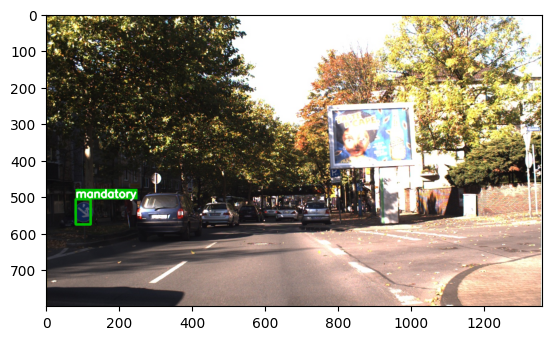

In [96]:
img_draw = visualizer.draw(img_draw, pred, model_input_shape, text_scale=1, text_thickness=3, bbox_thickness=5)
visualizer.visualize_by_plt(img_draw)